## Sex-related differences in the human microbiome using curatedMetagenomicData 3 and the python 3 language

### Paolo Manghi, (paolo.manghi@unitn.it)

### This notebook contains the instructions to run a meta-analysis of sex-related contrasts in the human gut microbiome, using **curatedMetagenomicDataCLI** and a set of freely-available python programs

The first step of our analysis is to install the **curatedMetagenomicDataCLI** workflow:
To do this, run:

If everything went fine, you now should be able to run:
**curatedMetagenomicData -h**
obtaining the following:

The flag "-m" will attach the per-sample metadata available in curatedMetagenomicData 3 to their taxonomic profiles.
We now switch to a python 3 set of instructions that can be used to perform the main analysis of Figure 2, panel a, of the paper "***". 

The following instruction are meant as an example and also to clarify some aspect of the inner-code: the whole analysis is avaiable, as explained, via command-line programs, at [https://github.com/waldronlab/curatedMetagenomicAnalyses/tree/main/python_tools] and can be all completed from the shell.

We must, so, first import the basic modules to work with cMDCLI in a meta-analytical way.
First, we have to retrieve the necessary codes from github:

In [2]:
## Imports section:
## We must import the basic modules to work
## with cMD 3 in a meta-analytical way

import sys

In [3]:
sys.path.append("curatedMetagenomicAnalyses/python_modules/")
sys.path.append("curatedMetagenomicAnalyses/python_tools/")

import pandas as pd
import numpy as np

## The following two modules handle either 
## a meta-analysis based on a std. linear model
## OR a std. differential abundance analysis.
## This is useful as some biological questions are
## commonly explorable just in one dataset.
from meta_analysis_runner import meta_analysis_with_linear_model
from meta_analysis_runner import analysis_with_linear_model

## Next, we import  

In [4]:
## Construction of the dataset
## The function select builds a dataset according to the 
## requirements/costraints passed by the user

## Its "help" page is the following.

In [50]:
## Now, the "Select" function can be import as a module and used:
## To to this, it is enough to pass it a dictionary of the parameters,
## as follows:

from meta_analysis_data import select

## Following from the "Help" page, we next try to build 
## a dataset to study the Sex-contrast in the healthy, human, gut microbiome:

params = {
    'input_folder': "species_abundances_from_cMD3CLI/",
    "output_dataset": "a_dataset_for_the_sex_contrast_in_gut_species.tsv",
    "min": ["age:16"],
    "max": [],
    "cat": ["study_condition:control", "body_site:stool"], 
    "multiple": -1,
    "min_perc": ["gender:25"],
    "cfd":["BMI"], 
    "iqr": [],
    "minmin": "gender:40",
    "study_identifier": "study_name", 
    "verbose": False, 
    "debug": False,
    "binary": [],
    "search": [],
    "exclude": []
}

## These are the parameters that are needed to narrow
## this dataset. Normally, these are inserted via command-line, 
## but python is flexible on this

In [51]:
## Now we write a dataset table: a dataset-table is meant 
## here as a table with Samples as columns-ID, and 
## metadata + features as index (row-names). Features are then
## distingushed from metadata based on the "feat-id" keyword.

select(params)

{'input_folder': 'species_abundances_from_cMD3CLI/', 'output_dataset': 'a_dataset_for_the_sex_contrast_in_gut_species.tsv', 'min': ['age:16'], 'max': [], 'cat': ['study_condition:control', 'body_site:stool'], 'multiple': -1, 'min_perc': ['gender:25'], 'cfd': ['BMI'], 'iqr': [], 'minmin': 'gender:40', 'study_identifier': 'study_name', 'verbose': False, 'debug': False, 'binary': [], 'search': [], 'exclude': []}


Now, you should have saved in your current working directory, a file named **a_dataset_for_the_sex_contrast_in_gut_species.tsv**. 

At June, 2021, this dataset should store 4007 sample-IDs (columns) + 1 column index.
The current dataset is not yet usabel to perform a meta-analysis as the compositional 
data returned by MetaPhlAn3 software are not recommended for work with most of statistical methods.

Among the trasformation more often applied, there are the *Centered-Log-Ratio* (CLR) and the *arcsin-square-root* of 
the relative-abundance-corresponding proportions. This last method is widely applied in meta-analyses on 
microbiome-related questions as it considers equally all the zeros independent from the dataset. 

We thus will apply the arcsin-square root, but a utility script is currently available to apply both.
The "help" page of such utility is the following:

In [52]:
## The general procedure to transform only the **features**
## in a dataset-merged-table is quite simple.
## We must first read the table we have created:
sex_contrast_dataset = pd.read_csv("a_dataset_for_the_sex_contrast_in_gut_species.tsv", sep="\t", \
        header=0, index_col=0, low_memory=False, engine="c").fillna("NA")

## We then identify it's features
feats = [j for j in sex_contrast_dataset.index.tolist() if ("s__" in j)]

## We transform the data
for sample in sex_contrast_dataset.columns.tolist():
    sex_contrast_dataset.loc[feats, sample] = sex_contrast_dataset.loc[feats, sample].values.astype(float)
    sex_contrast_dataset.loc[feats, sample] /= np.sum(sex_contrast_dataset.loc[feats, sample].values)
    sex_contrast_dataset.loc[feats, sample] = np.arcsin(np.sqrt(\
        sex_contrast_dataset.loc[feats, sample].values.astype(float)))
    
## Now that we have transformed the data we can save a table which is suitable for the analyses:
sex_contrast_dataset.index.name = "sample_id"
sex_contrast_dataset.to_csv("a_dataset_for_the_sex_contrast_in_gut_species_arcsin.tsv", sep="\t", \
        header=True, index=True)

It's now time to use the dataset we have created to perform a meta-analysis.
The meta-analysis we'll perform is a standard meta-analysis (e.g. a weigthed-average of several 
effect-sizes, computed over several, independent populations).

The effect-size will be in the class of the differences of means (Cohen's d) and will characterize 
the difference between males and females (men and women).

The only difference, with respect to a canonical paradigm of meta-analysis, is that we will extract, 
each time, **the cohen'd effect size from the sex-relative coefficient of an ordinary least squares (OLS)
model**. Beside being averaged over 15 populations, these effect-sizes will be so adjusted by age and by BMI
in addition.

Now, the program allowing you to run directly the meta-analysis is called **metaanalyze.py**, and 
asks for a short set of parameters in order to understand how to perform the desired meta-analysis.

We will now run, **manually**, the basic steps of this program, in order to show them explicitly:

In [53]:
## First, we reproduce part of the program's import section
from meta_analyses import paule_mandel_tau
from meta_analyses import RE_meta_binary
from meta_analyses import RE_meta

## we specify the important parameters
outfile = "sex_4007_individuals_meta_analysis"
heterogeneity = "PM" ## this corresponds to the default of the program
study_id = "study_name" ## this is needed in order to segregate the populations
type_of_analysis = "CLS" ## CLASSIFY (SEE AFTER)


We also need to specifiy a **formula** for the **model** that will be optimized before to compute the effect-size.
The model will be applied to all the features in **feats**. Given this, we don't have to specify the Y, but only the **X(s)**.

The first X will be the main predictor, and the effect-sizes will be computed on that.
The following X will be used to adjuste the model.

NOTE THAT:
1) Tough this is not needed for the main one, **categorical** covariates must be explicitly indicated via **C(name of c.)**.

2) Tough the first variable is automatically detected as categorical (if type_of_analysis == "CLS"), we must the same
    specify the **positive** and the **negative** direction of the analysis we are going to perform.

In [54]:
formula = "gender + age + BMI"
control_side, case_side = "female", "male"

We now can run the meta-analysis main module, **metaanalyze.py**.
The module can be run from command-line with a minimum parameters, provided that a suitable dataset has 
been built.

The "help" page of the **metaanalyze.py** is the following:

In [55]:
ma = meta_analysis_with_linear_model(\
    sex_contrast_dataset, 
    formula, \
    study_id, \
    feats, \
    outfile + ".tsv", \
    type_of_analysis, \
    heterogeneity, \
    pos=case_side, \
    neg=control_side
    )

In [56]:
ma.random_effect_regression_model()

k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii (14 studies) Random Effect Effect = -0.079 [H: 0.004 0.007  0.192]
k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanosphaera|s__Methanosphaera_cuniculi (3 studies) Random Effect Effect = -0.052 [H: 0.000 0.000  0.000]
k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanosphaera|s__Methanosphaera_stadtmanae (12 studies) Random Effect Effect = -0.007 [H: 0.007 0.010  0.334]
k__Archaea|p__Euryarchaeota|c__Thermoplasmata|o__Methanomassiliicoccales|f__Methanomassiliicoccaceae|g__Methanomassiliicoccus|s__Candidatus_Methanomassiliicoccus_intestinalis (6 studies) Random Effect Effect = -0.102 [H: 0.000 0.000  0.000]
k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum|s__Actinobaculum_sp_oral_taxon_183 

k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_pseudocatenulatum (14 studies) Random Effect Effect = -0.027 [H: 0.000 0.000  0.000]
k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_pseudolongum (7 studies) Random Effect Effect = 0.017 [H: 0.000 0.000  0.000]
k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_pullorum (6 studies) Random Effect Effect = 0.005 [H: 0.001 0.000  0.055]
k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_ruminantium (6 studies) Random Effect Effect = -0.001 [H: 0.000 0.000  0.031]
k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_saeculare (5 studies) Random Effect Effe

k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_cellulosilyticus (14 studies) Random Effect Effect = -0.132 [H: 0.000 0.000  0.000]
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_clarus (14 studies) Random Effect Effect = -0.002 [H: 0.004 0.004  0.209]
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_coprocola (13 studies) Random Effect Effect = 0.067 [H: 0.001 0.002  0.084]
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_coprophilus (14 studies) Random Effect Effect = 0.021 [H: 0.000 0.000  0.000]
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_dorei (14 studies) Random Effect Effect = -0.118 [H: 0.000 0.000  0.000]
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacter

k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Barnesiellaceae|g__Coprobacter|s__Coprobacter_fastidiosus (13 studies) Random Effect Effect = -0.158 [H: 0.000 0.000  0.000]
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Barnesiellaceae|g__Coprobacter|s__Coprobacter_secundus (13 studies) Random Effect Effect = -0.059 [H: 0.000 0.000  0.000]
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Barnesiellaceae|g__Coprobacter|s__Coprobacter_sp (4 studies) Random Effect Effect = -0.012 [H: 0.000 0.000  0.000]
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Muribaculaceae|g__Muribaculum|s__Muribaculum_intestinale (4 studies) Random Effect Effect = 0.020 [H: 0.006 0.007  0.494]
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Odoribacteraceae|g__Butyricimonas|s__Butyricimonas_synergistica (13 studies) Random Effect Effect = -0.085 [H: 0.000 0.000  0.000]
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__O

k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_CAG_891 (10 studies) Random Effect Effect = 0.039 [H: 0.008 0.013  0.413]
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_CAG_924 (6 studies) Random Effect Effect = -0.042 [H: 0.002 0.005  0.184]
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_S7_1_8 (3 studies) Random Effect Effect = -0.084 [H: 0.000 0.000  0.000]
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_stercorea (14 studies) Random Effect Effect = 0.116 [H: 0.002 0.003  0.094]
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_timonensis (12 studies) Random Effect Effect = -0.092 [H: 0.005 0.005  0.274]
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__

k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_faecalis (13 studies) Random Effect Effect = -0.048 [H: 0.000 0.000  0.000]
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_faecium (14 studies) Random Effect Effect = -0.034 [H: 0.000 0.000  0.000]
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_gallinarum (10 studies) Random Effect Effect = -0.034 [H: 0.004 0.006  0.218]
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_hirae (5 studies) Random Effect Effect = -0.063 [H: 0.000 0.000  0.000]
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_mundtii (4 studies) Random Effect Effect = -0.053 [H: 0.000 0.000  0.000]
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus

k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_gelidum (6 studies) Random Effect Effect = 0.068 [H: 0.016 0.020  0.642]
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_lactis (10 studies) Random Effect Effect = -0.037 [H: 0.000 0.000  0.000]
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_mesenteroides (8 studies) Random Effect Effect = -0.042 [H: 0.010 0.023  0.467]
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_pseudomesenteroides (5 studies) Random Effect Effect = -0.000 [H: 0.002 0.002  0.236]
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Weissella|s__Weissella_cibaria (13 studies) Random Effect Effect = 0.000 [H: 0.002 0.002  0.095]
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Weissell

k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_vestibularis (13 studies) Random Effect Effect = -0.011 [H: 0.002 0.001  0.127]
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_viridans (6 studies) Random Effect Effect = -0.039 [H: 0.000 0.000  0.000]
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Catabacteriaceae|g__Catabacter|s__Catabacter_hongkongensis (12 studies) Random Effect Effect = -0.036 [H: 0.000 0.000  0.000]
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Christensenellaceae|g__Christensenella|s__Christensenella_minuta (12 studies) Random Effect Effect = -0.067 [H: 0.000 0.000  0.000]
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Butyricicoccus|s__Butyricicoccus_pullicaecorum (12 studies) Random Effect Effect = 0.005 [H: 0.008 0.007  0.369]
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales

k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_unclassified|g__Clostridiales_unclassified|s__Clostridiales_bacterium_CHKCI006 (8 studies) Random Effect Effect = -0.080 [H: 0.000 0.000  0.000]
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_unclassified|g__Intestinimonas|s__Intestinimonas_butyriciproducens (14 studies) Random Effect Effect = -0.203 [H: 0.000 0.000  0.000]
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_unclassified|g__Lawsonibacter|s__Lawsonibacter_asaccharolyticus (14 studies) Random Effect Effect = -0.090 [H: 0.004 0.007  0.219]
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_unclassified|g__Monoglobus|s__Monoglobus_pectinilyticus (12 studies) Random Effect Effect = -0.109 [H: 0.014 0.026  0.505]
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Anaerofustis|s__Anaerofustis_stercorihominis (9 studies) Random Effect Effect = -0.066 [H: 0.

k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Dorea|s__Dorea_longicatena (14 studies) Random Effect Effect = 0.117 [H: 0.000 0.000  0.000]
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Dorea|s__Dorea_sp_CAG_317 (11 studies) Random Effect Effect = -0.066 [H: 0.005 0.004  0.294]
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Eisenbergiella|s__Eisenbergiella_massiliensis (13 studies) Random Effect Effect = -0.114 [H: 0.002 0.002  0.143]
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Eisenbergiella|s__Eisenbergiella_tayi (13 studies) Random Effect Effect = -0.171 [H: 0.000 0.000  0.000]
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Faecalicatena|s__Faecalicatena_orotica (8 studies) Random Effect Effect = -0.055 [H: 0.000 0.000  0.025]
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Fusicatenibacter|

k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Clostridioides|s__Clostridioides_difficile (7 studies) Random Effect Effect = -0.016 [H: 0.018 0.014  0.464]
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Intestinibacter|s__Intestinibacter_bartlettii (14 studies) Random Effect Effect = 0.028 [H: 0.007 0.011  0.318]
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Paeniclostridium|s__Paeniclostridium_sordellii (5 studies) Random Effect Effect = -0.021 [H: 0.006 0.005  0.340]
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcaceae_unclassified|s__Clostridium_hiranonis (6 studies) Random Effect Effect = -0.008 [H: 0.007 0.008  0.229]
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcus|s__Peptostreptococcus_anaerobius (5 studies) Random Effect Effect = -0.013 [H: 0.002 0.002  0.23

k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Subdoligranulum|s__Subdoligranulum_variabile (5 studies) Random Effect Effect = -0.073 [H: 0.001 0.002  0.151]
k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Absiella|s__Absiella_dolichum (11 studies) Random Effect Effect = 0.067 [H: 0.000 0.000  0.000]
k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Candidatus_Stoquefichus|s__Candidatus_Stoquefichus_sp_KLE1796 (9 studies) Random Effect Effect = 0.042 [H: 0.007 0.007  0.376]
k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Catenibacterium|s__Catenibacterium_mitsuokai (14 studies) Random Effect Effect = 0.195 [H: 0.000 0.000  0.000]
k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Coprobacillus|s__Coprobacillus_cateniformis (13 studies) Random Effect Effect = -0.072 [H: 0.000 0.0

k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Selenomonadaceae|g__Megamonas|s__Megamonas_rupellensis (8 studies) Random Effect Effect = -0.014 [H: 0.000 0.000  0.000]
k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Selenomonadaceae|g__Mitsuokella|s__Mitsuokella_jalaludinii (12 studies) Random Effect Effect = 0.057 [H: 0.002 0.002  0.110]
k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Selenomonadaceae|g__Mitsuokella|s__Mitsuokella_multacida (14 studies) Random Effect Effect = 0.088 [H: 0.009 0.014  0.364]
k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Selenomonadaceae|g__Selenomonas|s__Selenomonas_noxia (6 studies) Random Effect Effect = -0.002 [H: 0.004 0.006  0.185]
k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Allisonella|s__Allisonella_histaminiformans (14 studies) Random Effect Effect = 0.161 [H: 0.000 0.000  0.000]
k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellale

k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_periodonticum (9 studies) Random Effect Effect = 0.115 [H: 0.000 0.000  0.000]
k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_sp_CAG_439 (8 studies) Random Effect Effect = -0.059 [H: 0.000 0.000  0.000]
k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_ulcerans (7 studies) Random Effect Effect = 0.044 [H: 0.000 0.000  0.000]
k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_varium (9 studies) Random Effect Effect = 0.023 [H: 0.000 0.000  0.000]
k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae|g__Leptotrichia|s__Leptotrichia_wadei (3 studies) Random Effect Effect = -0.118 [H: 0.017 0.023  0.368]
k__Bacteria|p__Fusobacteria|c__Fusobac

k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Citrobacter|s__Citrobacter_braakii (10 studies) Random Effect Effect = 0.060 [H: 0.003 0.002  0.199]
k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Citrobacter|s__Citrobacter_europaeus (10 studies) Random Effect Effect = 0.032 [H: 0.006 0.005  0.276]
k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Citrobacter|s__Citrobacter_farmeri (3 studies) Random Effect Effect = 0.079 [H: 0.004 0.006  0.225]
k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Citrobacter|s__Citrobacter_freundii (11 studies) Random Effect Effect = -0.027 [H: 0.000 0.000  0.000]
k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Citrobacter|s__Citrobacter_koseri (10 studies) Random Effect Effect = -0.054 [H: 0.000 0.000  0.000]
k_

k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Aggregatibacter|s__Aggregatibacter_sp_oral_taxon_458 (3 studies) Random Effect Effect = 0.056 [H: 0.043 0.037  0.644]
k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_haemolyticus (4 studies) Random Effect Effect = 0.082 [H: 0.015 0.013  0.508]
k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_parahaemolyticus (6 studies) Random Effect Effect = 0.109 [H: 0.000 0.000  0.000]
k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_parainfluenzae (14 studies) Random Effect Effect = 0.086 [H: 0.016 0.022  0.523]
k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_paraphrohaemolyticus (8 studies) Random Effect Effect = 0.073 [H: 0.

Now that we have computed a meta-analysis, we want to plot it. Meta-analyses and Metagenomics are both dealing
each with a problem of multidimensionality of the results, so coupling them requires to do our best to fit the 
different layers of results in one figure.

In particular, we can plot many forest-plots in a single figure with the script: **draw_figure_with_ma.py**.
Its "help" page is the following:

In order to call program from python, we have to prepare a dictionary, faking its command-line arguments.
Also, the program is able to plot several meta-analysis in the same set of axes, tough we will for now 
limit ourselves to the **basic usage**

['DhakanDB_2019_Effect', 'JieZ_2017_Effect', 'SchirmerM_2016_Effect', 'HMP_2012_Effect', 'KeohaneDM_2020_Effect', 'PasolliE_2019_Effect', 'NielsenHB_2014_Effect', 'LifeLinesDeep_2016_Effect', 'ZhuF_2020_Effect', 'AsnicarF_2021_Effect', 'DeFilippisF_2019_Effect', 'YachidaS_2019_Effect', 'QinN_2014_Effect', 'QinJ_2012_Effect'] 14 questi sono gli effetti singoli
['DhakanDB_2019_Qvalue', 'JieZ_2017_Qvalue', 'SchirmerM_2016_Qvalue', 'HMP_2012_Qvalue', 'KeohaneDM_2020_Qvalue', 'PasolliE_2019_Qvalue', 'NielsenHB_2014_Qvalue', 'LifeLinesDeep_2016_Qvalue', 'ZhuF_2020_Qvalue', 'AsnicarF_2021_Qvalue', 'DeFilippisF_2019_Qvalue', 'YachidaS_2019_Qvalue', 'QinN_2014_Qvalue', 'QinJ_2012_Qvalue'] 14  questi sono i Qvalue singoli
412
412
412
412
sex: male 9
9.0


curatedMetagenomicAnalyses/python_tools/draw_figure_with_ma.py:455: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( ax.get_xticks(), fontsize=24 )


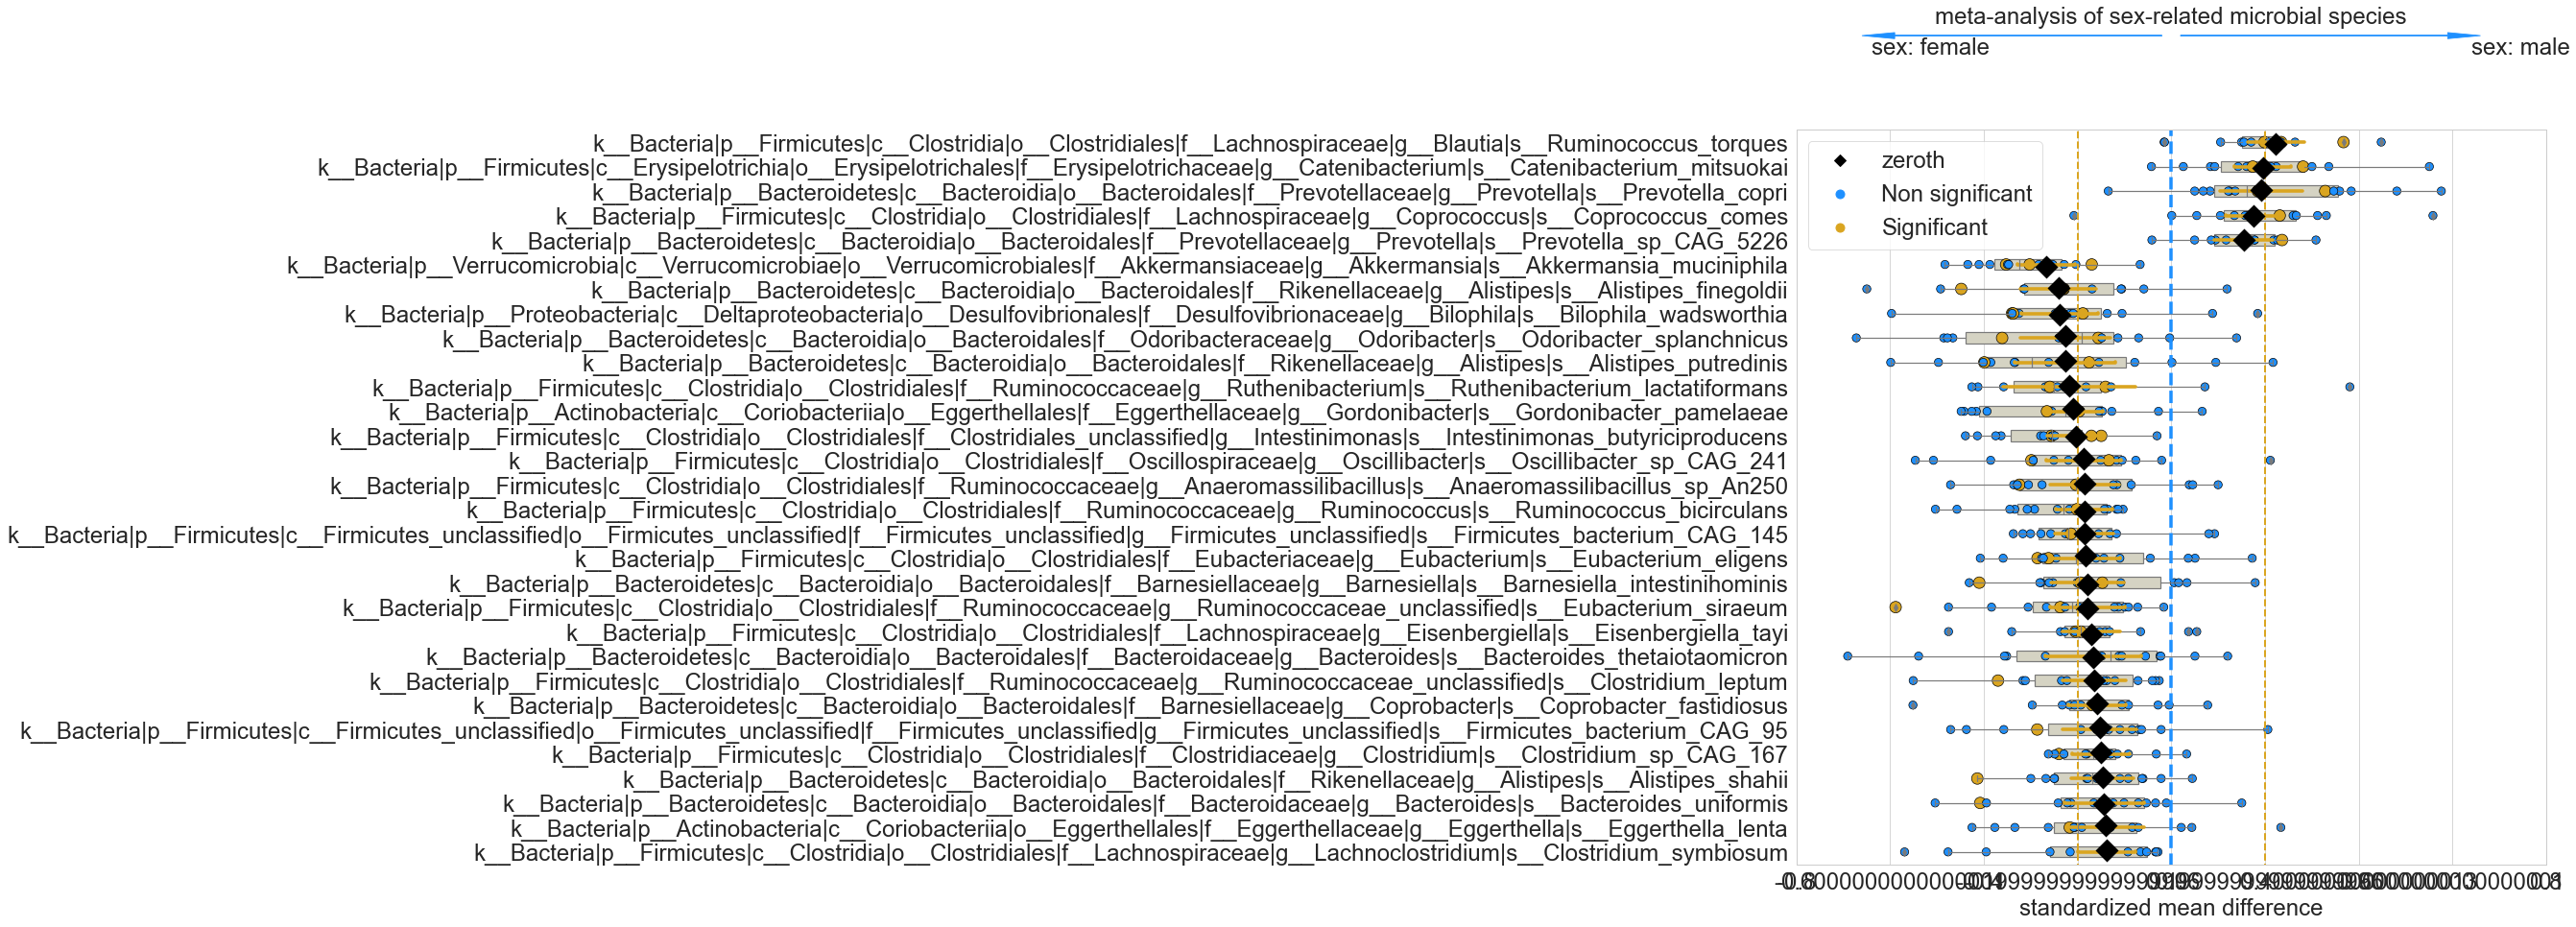

In [5]:
figure_params = {
    "metaanalysis": ["sex_4007_individuals_meta_analysis.tsv"],
    "narrowed": True,
    "boxes": True,
    "relative_abundances": ["a_dataset_for_the_sex_contrast_in_gut_species.tsv"],
    "imp": 30, 
    "how": "first",
    "positive_direction": "sex: male",
    "negative_direction": "sex: female",
    "x_axis": "standardized mean difference",
    "y_axis": "",
    "title": "meta-analysis of sex-related microbial species",
    "e_suff": ["_Effect"],
    "q_suff": ["_Qvalue"],
    "prevalence": [""],
    "min_prevalence": [0.01],
    "min_ab": [0.000],
    "min_studies": [4],
    "markers": False,
    "outfile": None,
    "random_effect": ["RE_Effect"],
    "confint": ["RE_conf_int"],
    "random_effect_q": ["RE_Effect_Qvalue"],
    "color_red": ["goldenrod"],
    "color_blue": ["dodgerblue"],
    "color_black": ["black"],
    "diam_marker": ["D"],
    "important_lines": [0.20],
    "a_single": 0.2,
    "a_random": 0.05, 
    "dotsize": 9,
    "diamsize": 17,
    "neg_max_rho": 0.8,
    "pos_max_rho": 0.8,
    "legloc": "best"
}

## We then import the main function
from draw_figure_with_ma import draw_figure

## We run it
draw_figure(figure_params, show=True)